In [229]:
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

def preprocess(df):
    soil_columns = [col for col in df.columns if col.startswith('Soil_Type')]
    df['Soil_Type_Cat'] = df[soil_columns].idxmax(axis=1)
    label_encoder = LabelEncoder()
    df['Soil_Type_Cat'] = label_encoder.fit_transform(df['Soil_Type_Cat'])
    df = df.drop(columns=soil_columns)


    df['Euclidean_Distance_To_Hydrology'] = np.sqrt(
        df['Horizontal_Distance_To_Hydrology'] ** 2 +
        df['Vertical_Distance_To_Hydrology'] ** 2
    )

    df['Mean_Hillshade'] = df[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].mean(axis=1)

    df['Hydro_Elev_Diff'] = df['Elevation'] - df['Vertical_Distance_To_Hydrology']

    df['Elevation_Times_HE_Diff'] = df['Elevation'] * df['Hydro_Elev_Diff']
    df['Elevation_Band'] = pd.cut(df['Elevation'], bins=10)
    # Convert to numerical codes
    df['Elevation_Band'] = df['Elevation_Band'].cat.codes
    df['Total_Horizontal_Distance'] = (
        df['Horizontal_Distance_To_Hydrology'] +
        df['Horizontal_Distance_To_Roadways'] +
        df['Horizontal_Distance_To_Fire_Points']
    )
    df['Aspect_Quadrant'] = pd.cut(
    df['Aspect'], bins=[0, 90, 180, 270, 360], labels=False, include_lowest=True
    )
    elevation_threshold = 3550
    hydro_elevation_threshold = 3130
    df['Elevation_Above_Threshold'] = (df['Elevation'] > elevation_threshold).astype(int)
    df['Hydro_Elev_Diff_Above_Threshold'] = (df['Hydro_Elev_Diff'] > hydro_elevation_threshold).astype(int)
    df['Elev_Hydro_Interaction'] = df['Elevation_Above_Threshold'] * df['Hydro_Elev_Diff_Above_Threshold']
    return df

def create_gmm_features(X, feature, n_components=2):
    # Fit GMM
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X[[feature]])
    # Predict probabilities
    probs = gmm.predict_proba(X[[feature]])
    # Add probabilities as features
    for i in range(n_components):
        X[f'{feature}_GMM_{i}'] = probs[:, i]
    return X

from sklearn.neighbors import KernelDensity

def create_kde_features(X_train, X_test, feature, bandwidth=0.5):
    # Fit KDE on the training data
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(X_train[[feature]])
    # Compute the log density scores
    X_train[f'{feature}_KDE'] = kde.score_samples(X_train[[feature]])
    X_test[f'{feature}_KDE'] = kde.score_samples(X_test[[feature]])
    return X_train, X_test



In [234]:
# Load the dataset
df = pd.read_csv('train.csv')

# Apply preprocessing
df = preprocess(df)

# Separate features and target
X = df.drop(columns=['Cover_Type'])
y = df['Cover_Type']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply GMM transformations
X_train = create_gmm_features(X_train, 'Elevation', n_components=2)
X_train = create_gmm_features(X_train, 'Hydro_Elev_Diff', n_components=2)

X_test = create_gmm_features(X_test, 'Elevation', n_components=2)
X_test = create_gmm_features(X_test, 'Hydro_Elev_Diff', n_components=2)

# Apply KDE transformations
X_train, X_test = create_kde_features(X_train, X_test, 'Elevation')
X_train, X_test = create_kde_features(X_train, X_test, 'Hydro_Elev_Diff')

# Add log-transformed features
X_train['Elevation_Log'] = np.log1p(X_train['Elevation'] - X_train['Elevation'].min() + X_train['Elevation'].max())
X_test['Elevation_Log'] = np.log1p(X_test['Elevation'] - X_train['Elevation'].min() + X_train['Elevation'].max())

X_train['Hydro_Elev_Diff_Log'] = np.log1p(X_train['Hydro_Elev_Diff'] - X_train['Hydro_Elev_Diff'].min() + X_train['Hydro_Elev_Diff'].max())
X_test['Hydro_Elev_Diff_Log'] = np.log1p(X_test['Hydro_Elev_Diff'] - X_train['Hydro_Elev_Diff'].min() + X_train['Hydro_Elev_Diff'].max())

# Select only the most important features identified by PCA
important_features = [
    'Total_Horizontal_Distance', 'Elev_Hydro_Interaction', 'Id',
    'Mean_Hillshade', 'Hydro_Elev_Diff_KDE', 'Slope', 'Elevation_Log',
    'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Hydrology',
    'Soil_Type_Cat', 'Horizontal_Distance_To_Fire_Points', 'Hillshade_3pm',
    'Aspect', 'Hillshade_Noon', 'Hydro_Elev_Diff_Log', 'Hillshade_9am',
    'Elevation_Times_HE_Diff', 'Wilderness_Area2', 'Wilderness_Area3',
    'Elevation_KDE', 'Elevation_Above_Threshold',
    'Hydro_Elev_Diff_Above_Threshold', 'Hydro_Elev_Diff',
    'Wilderness_Area1', 'Horizontal_Distance_To_Roadways', 'Elevation',
    'Wilderness_Area4', 'Euclidean_Distance_To_Hydrology'
]

# Reduce X_train and X_test to only the selected features
X_train = X_train[important_features]
X_test = X_test[important_features]

# Define custom class weights to penalize confusions between 1 and 2
class_weights = {1: 3.0, 2: 3.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0}
sparams = {'n_estimators': 710, 'learning_rate': 0.0948834313338604, 'max_depth': 12, 'num_leaves': 61, 'min_data_in_leaf': 16, 'feature_fraction': 0.5137033255698681, 'bagging_fraction': 0.9833914267242817, 'bagging_freq': 2, 'lambda_l1': 0.02222566051401023, 'lambda_l2': 0.04814966320707176}
# Initialize the LGBMClassifier with the custom class weights
lgbm_model = LGBMClassifier(class_weight=class_weights, **sparams)

# Train the model
lgbm_model.fit(X_train, y_train)

# Make predictions
y_pred = lgbm_model.predict(X_test)
y_pred_train = lgbm_model.predict(X_train)

# Evaluate the model's performance
test_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train, y_pred_train)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Optional: Generate a classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Train Accuracy: 1.0000
Test Accuracy: 0.9054

Classification Report:
              precision    recall  f1-score   support

           1       0.82      0.84      0.83       427
           2       0.85      0.77      0.81       464
           3       0.92      0.92      0.92       400
           4       0.96      0.97      0.96       436
           5       0.91      0.96      0.94       452
           6       0.91      0.92      0.91       415
           7       0.96      0.97      0.97       430

    accuracy                           0.91      3024
   macro avg       0.91      0.91      0.91      3024
weighted avg       0.90      0.91      0.90      3024



In [225]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('train.csv')

df = preprocess(df)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = create_gmm_features(X_train, 'Elevation', n_components=2)
X_train = create_gmm_features(X_train, 'Hydro_Elev_Diff', n_components=2)

X_test = create_gmm_features(X_test, 'Elevation', n_components=2)
X_test = create_gmm_features(X_test, 'Hydro_Elev_Diff',n_components=2)

X_train, X_test = create_kde_features(X_train, X_test, 'Elevation')
X_train, X_test = create_kde_features(X_train, X_test, 'Hydro_Elev_Diff')
X_train['Elevation_Log'] = np.log1p(X_train['Elevation'] - X_train['Elevation'].min() + X_train['Elevation'].max())
X_test['Elevation_Log'] = np.log1p(X_test['Elevation'] - X_train['Elevation'].min() + X_train['Elevation'].max())

X_train['Hydro_Elev_Diff_Log'] = np.log1p(X_train['Hydro_Elev_Diff'] - X_train['Hydro_Elev_Diff'].min() + X_train['Hydro_Elev_Diff'].max())
X_test['Hydro_Elev_Diff_Log'] = np.log1p(X_test['Hydro_Elev_Diff'] - X_train['Hydro_Elev_Diff'].min() + X_train['Hydro_Elev_Diff'].max())

# Standardize the data to have zero mean and unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Calculate explained variance ratio to determine the number of components to keep
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Choose the number of components that explain at least 95% of the variance
n_components = np.argmax(explained_variance_ratio >= 0.95) + 1
print(f"Number of components explaining 95% of variance: {n_components}")

# Reapply PCA with the selected number of components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Convert PCA results to DataFrame (optional for better readability)
X_train_pca_df = pd.DataFrame(X_train_pca, columns=[f'PCA_{i+1}' for i in range(n_components)])
X_test_pca_df = pd.DataFrame(X_test_pca, columns=[f'PCA_{i+1}' for i in range(n_components)])

# Map PCA components to original features
pca_components = pd.DataFrame(pca.components_, columns=X_train.columns, index=[f'PCA_{i+1}' for i in range(n_components)])
print("PCA Components (Loadings):")
print(pca_components)

# Identify most important features contributing to each PCA component
important_features = {}
for component in pca_components.index:
    top_features = pca_components.loc[component].abs().sort_values(ascending=False).head(5)
    print(f"\nTop 5 features for {component}:")
    print(top_features)
    important_features[component] = top_features.index.tolist()

# Flatten the list of important features
all_important_features = set([feature for features in important_features.values() for feature in features])
print("\nMost relevant features across all components:")
print(all_important_features)

# Filter original dataset to retain only the most important features
X_train_reduced = X_train[list(all_important_features)]
X_test_reduced = X_test[list(all_important_features)]

print("\nReduced dataset features:")
print(X_train_reduced.columns)

KeyError: "['Hydro_Elev_Diff_KDE', 'Elevation_Log', 'Hydro_Elev_Diff_Log', 'Elevation_KDE'] not in index"

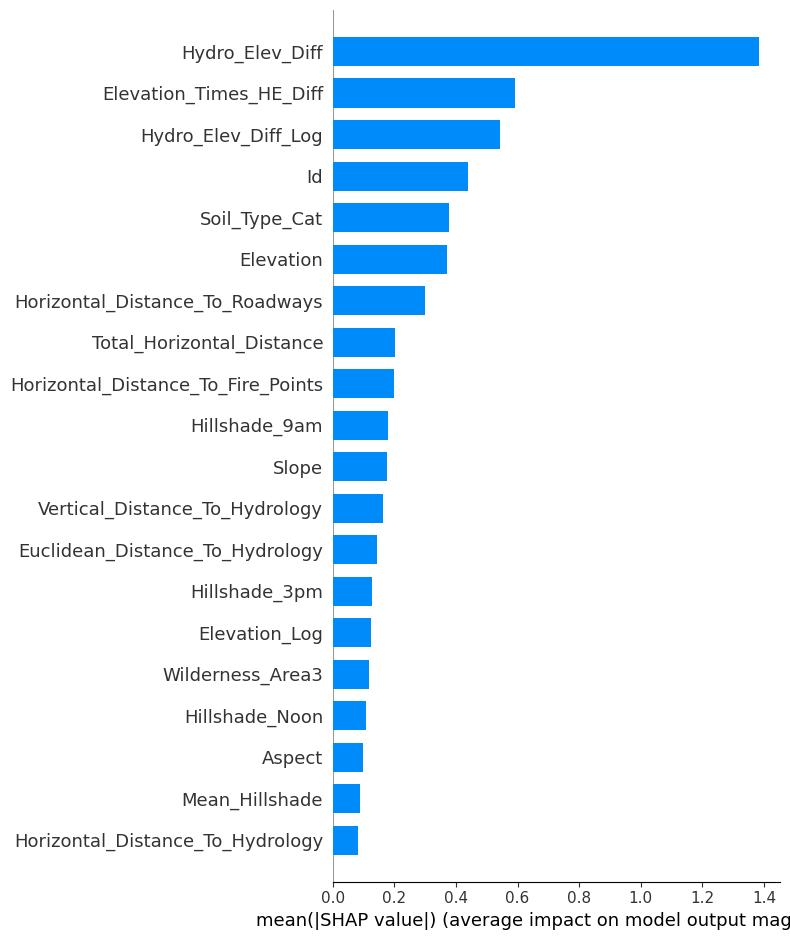

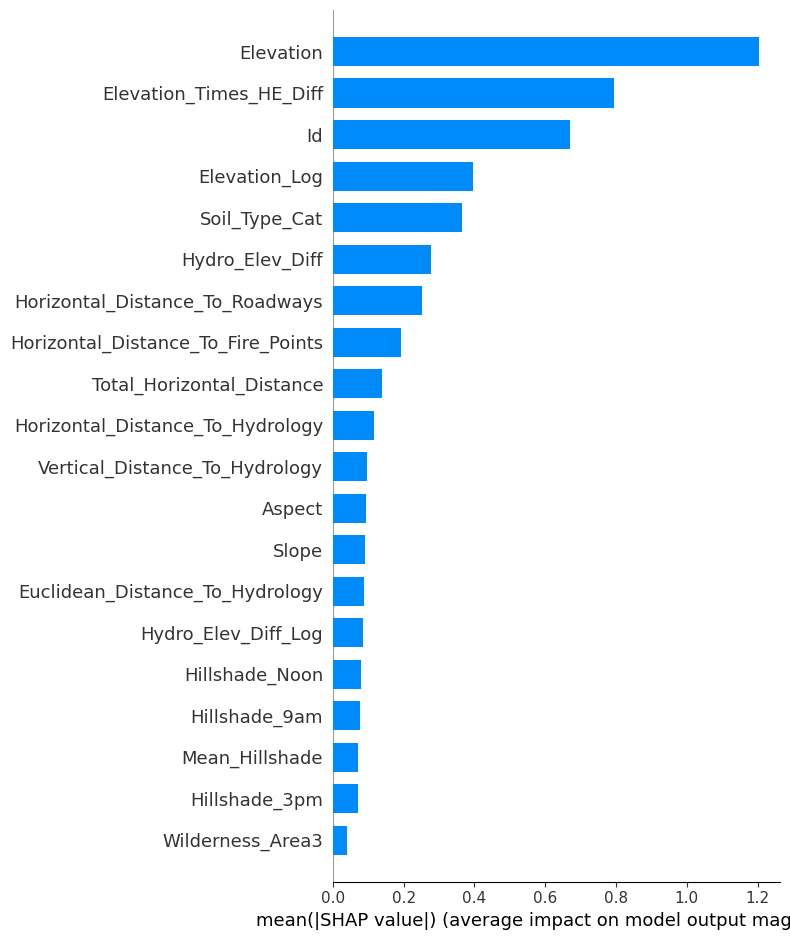

In [217]:
import shap
# For LightGBM
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(X_test)

# Adjust SHAP values for correct shape
# SHAP summary plot for class 1
shap.summary_plot(shap_values[:,:,0], X_test, plot_type="bar")
# SHAP summary plot for class 2
shap.summary_plot(shap_values[:,:,1], X_test, plot_type="bar")


                               Feature  Importance
2                                   Id       15669
10  Horizontal_Distance_To_Fire_Points       12653
24     Horizontal_Distance_To_Roadways       12293
0            Total_Horizontal_Distance       10591
4                  Hydro_Elev_Diff_KDE        9129
14                 Hydro_Elev_Diff_Log        8045
12                              Aspect        7913
7       Vertical_Distance_To_Hydrology        7635
19                       Elevation_KDE        7343
6                        Elevation_Log        7186
15                       Hillshade_9am        7097
11                       Hillshade_3pm        6776
27     Euclidean_Distance_To_Hydrology        6666
3                       Mean_Hillshade        6281
9                        Soil_Type_Cat        5896
16             Elevation_Times_HE_Diff        5690
13                      Hillshade_Noon        5435
8     Horizontal_Distance_To_Hydrology        5316
5                              

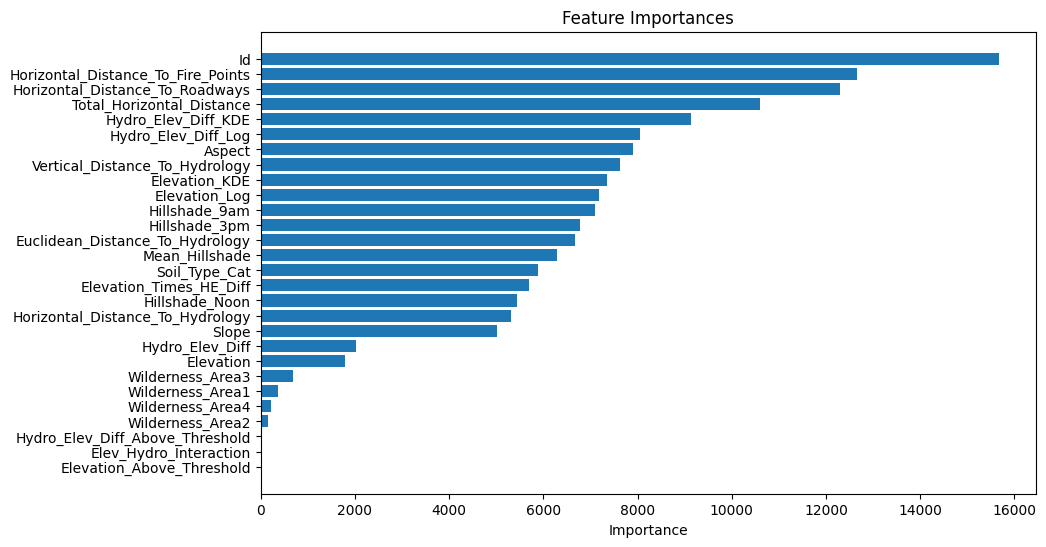

In [227]:
import matplotlib.pyplot as plt
import lightgbm as lgb

# Get feature importances
feature_importances = lgbm_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)
# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()


In [149]:
X_train.columns

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type_Cat', 'Euclidean_Distance_To_Hydrology',
       'Mean_Hillshade', 'Hydro_Elev_Diff', 'Total_Horizontal_Distance',
       'Elevation_Above_Threshold', 'Cluster', 'GMM_Cluster'],
      dtype='object')

In [150]:
df.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Wilderness_Area4,Cover_Type,Soil_Type_Cat,Euclidean_Distance_To_Hydrology,Mean_Hillshade,Hydro_Elev_Diff,Total_Horizontal_Distance,Elevation_Above_Threshold,Cluster,GMM_Cluster
0,242642,2881,130,22,210,54,1020,250,221,88,...,0,1,22,216.831732,186.333333,2827,1572,1,3,4
1,309891,3005,351,14,242,-16,1371,194,215,159,...,0,1,15,242.528349,189.333333,3021,2455,1,0,4
2,287847,3226,63,14,618,2,1092,232,210,107,...,0,1,20,618.003236,183.000000,3224,3728,1,0,4
3,516307,3298,317,8,661,60,752,198,233,174,...,0,1,14,663.717560,201.666667,3238,2661,1,0,1
4,124860,3080,35,6,175,26,3705,219,227,144,...,0,1,15,176.920886,196.666667,3054,6553,1,1,1


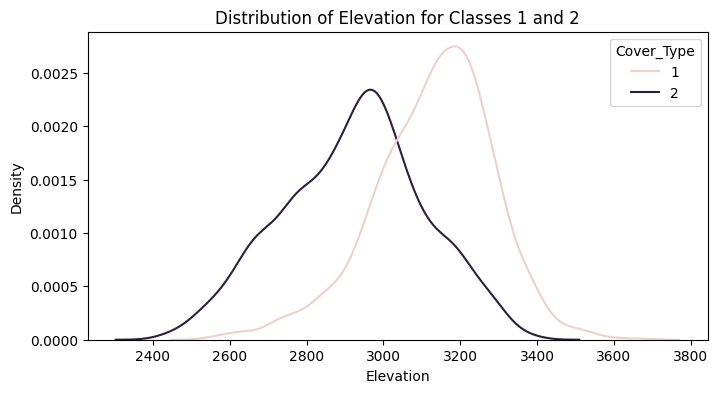

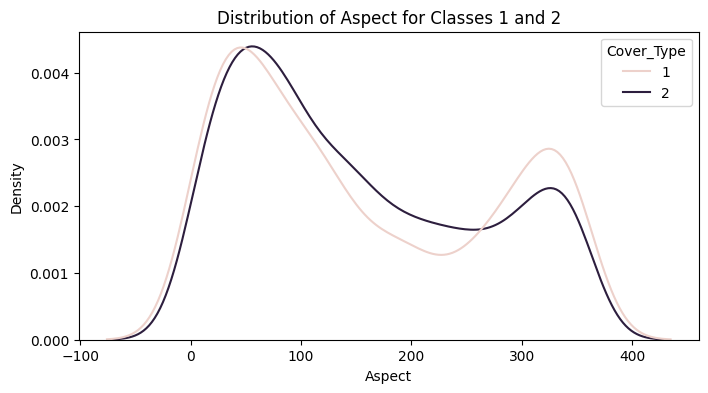

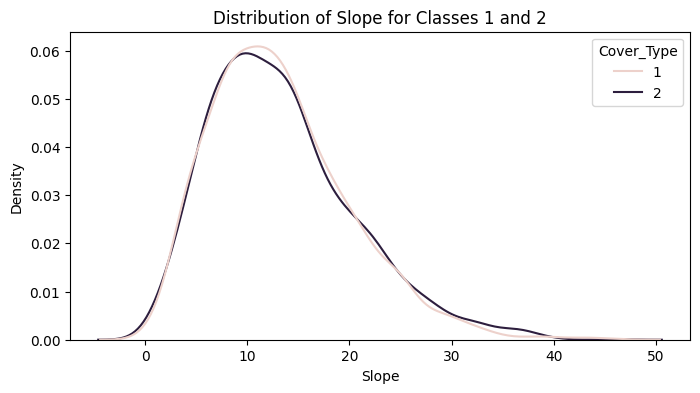

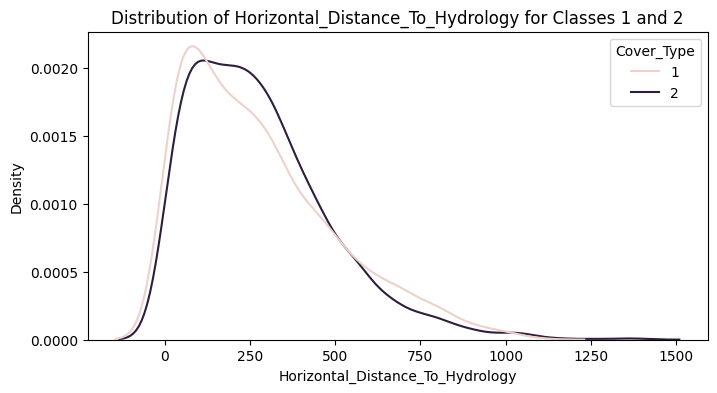

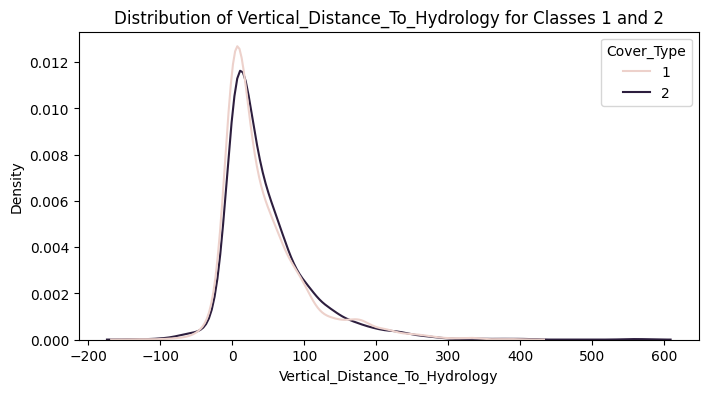

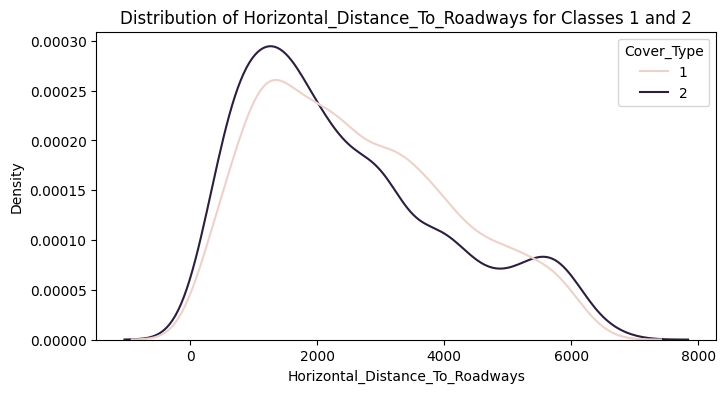

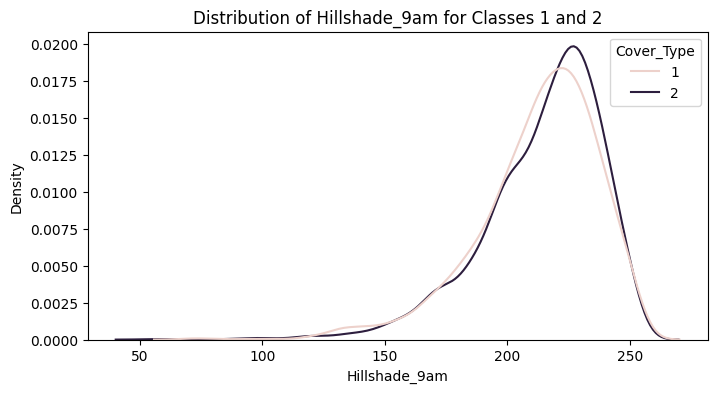

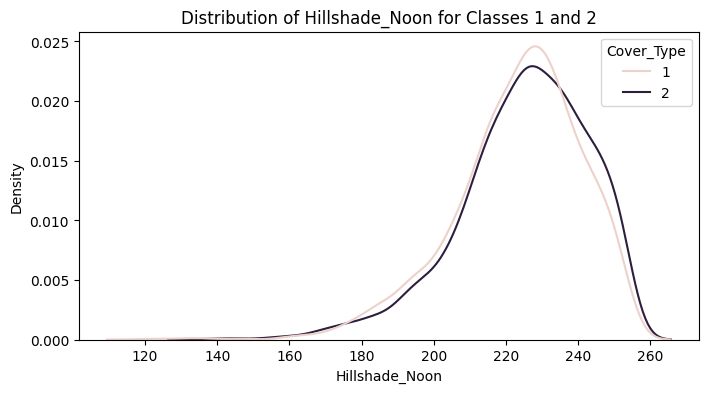

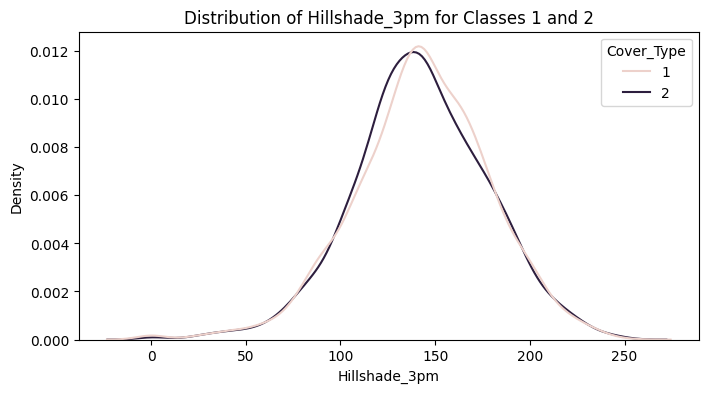

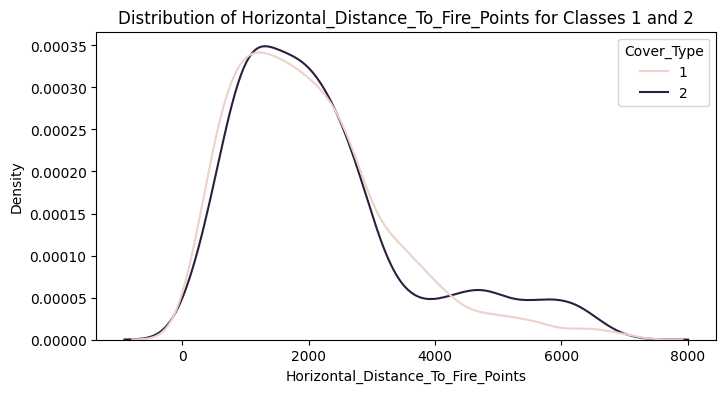

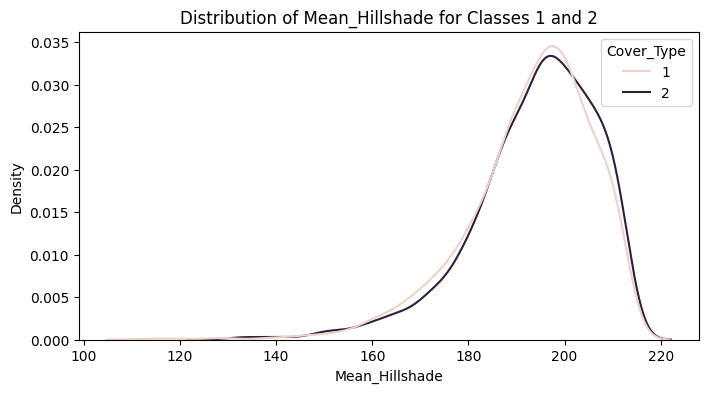

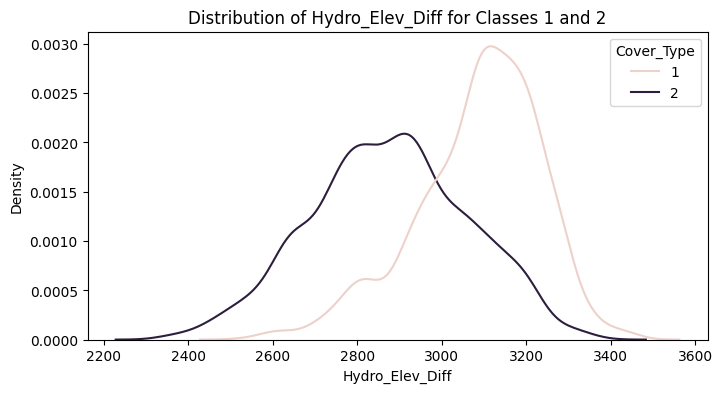

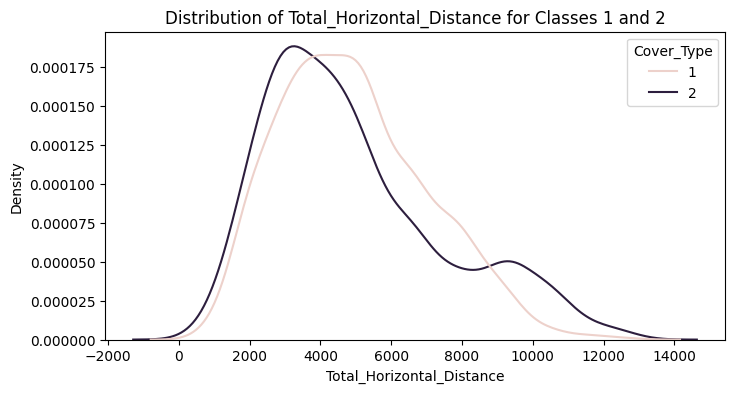

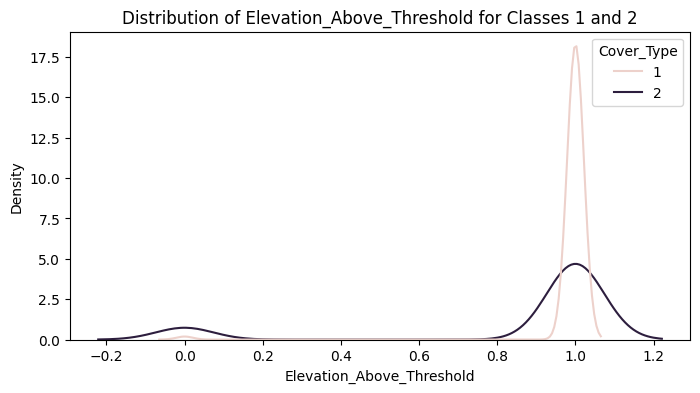

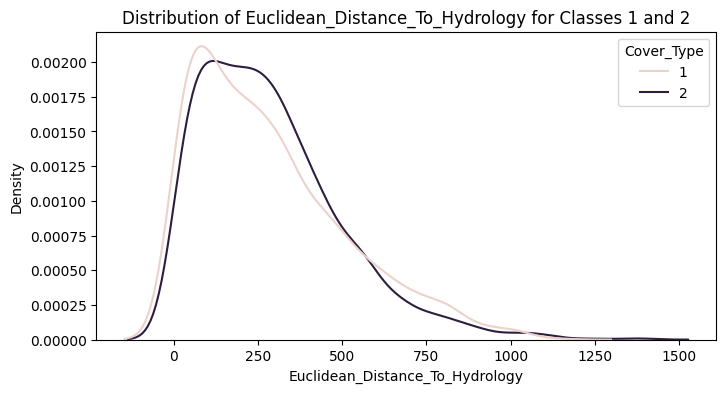

In [151]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select data for classes 1 and 2
data_classes_1_2 = df[df['Cover_Type'].isin([1, 2])]

# List of numerical features
numerical_columns = [
    'Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
    'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
    'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 
    'Horizontal_Distance_To_Fire_Points','Mean_Hillshade','Hydro_Elev_Diff','Total_Horizontal_Distance','Elevation_Above_Threshold', 'Euclidean_Distance_To_Hydrology',
]

# Plot distributions
for feature in numerical_columns:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=data_classes_1_2, x=feature, hue='Cover_Type', common_norm=False)
    plt.title(f'Distribution of {feature} for Classes 1 and 2')
    plt.show()


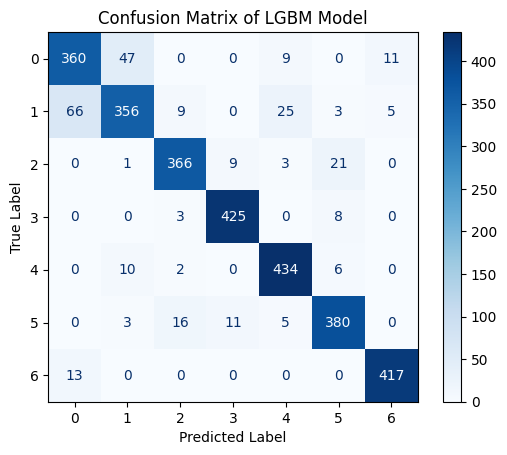

In [235]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')  # Use a color map for clarity
plt.title("Confusion Matrix of LGBM Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [153]:
lgbm_model = LGBMClassifier(**l[0])
lgbm_model.fit(X_scaled, y)

LGBMClassifier(bagging_fraction=0.9, bagging_freq=5, feature_fraction=0.7,
               lambda_l1=0.05, lambda_l2=0.05, learning_rate=0.05, max_depth=10,
               min_data_in_leaf=30, n_estimators=500, num_leaves=50,
               random_state=42, verbosity=-1)

In [159]:
df_subs = pd.read_csv('test-full.csv')
df_subs['Soil_Type_Cat'] = df_subs[soil_columns].idxmax(axis=1)
label_encoder = LabelEncoder()
df_subs['Soil_Type_Cat'] = label_encoder.fit_transform(df_subs['Soil_Type_Cat'])
df_subs = df_subs.drop(columns=soil_columns)


df_subs['Euclidean_Distance_To_Hydrology'] = np.sqrt(
    df_subs['Horizontal_Distance_To_Hydrology'] ** 2 +
    df_subs['Vertical_Distance_To_Hydrology'] ** 2
)

df_subs['Mean_Hillshade'] = df_subs[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].mean(axis=1)

df_subs['Hydro_Elev_Diff'] = df_subs['Elevation'] - df_subs['Vertical_Distance_To_Hydrology']
elevation_threshold = 2700
df_subs['Elevation_Above_Threshold'] = (df_subs['Elevation'] > elevation_threshold).astype(int)

df_subs['Total_Horizontal_Distance'] = (
    df_subs['Horizontal_Distance_To_Hydrology'] +
    df_subs['Horizontal_Distance_To_Roadways'] +
    df_subs['Horizontal_Distance_To_Fire_Points']
)

df_subs['Cluster'] = kmeans.predict(df_subs[numerical_features])

df_subs['GMM_Cluster'] = gmm.predict(df_subs[numerical_features])


df_subs[numerical_features] = scaler.transform(df_subs[numerical_features])
submission_preds = pd.DataFrame(lgbm_model.predict(df_subs), columns=['Cover_Type'])
submission_preds.to_csv('submission.csv', index=True)

In [160]:

# Load the CSV file
df = pd.read_csv('submission.csv')

# Increment the 'Id' column by 1
df['Id'] = df['Id'] + 1

# Save the modified DataFrame back to CSV
df.to_csv('submission1.csv', index=False)


In [233]:
import optuna
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, classification_report, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score
from functools import partial

# Define the objective function for Optuna
def objective(trial, X_train, y_train):
    # Suggest hyperparameters
    param_grid = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 1.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 1.0),
    }
    
    # Add class weights for emphasizing classes 1 and 2
    class_weights = {1: 3.0, 2: 3.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0}
    param_grid['class_weight'] = class_weights

    # Initialize the model
    model = LGBMClassifier(**param_grid, random_state=42, verbose=-1)

    # Perform cross-validation to evaluate F1 score
    f1_scorer = make_scorer(f1_score, average='weighted')
    scores = cross_val_score(model, X_train, y_train, scoring=f1_scorer, cv=3, n_jobs=-1)
    
    # Return the mean weighted F1 score
    return scores.mean()

# Prepare the dataset
df = pd.read_csv('train.csv')
df = preprocess(df)

X = df.drop(columns=['Cover_Type'])
y = df['Cover_Type']

# Split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature engineering (apply transformations and feature selection)
X_train = create_gmm_features(X_train, 'Elevation', n_components=2)
X_train = create_gmm_features(X_train, 'Hydro_Elev_Diff', n_components=2)
X_test = create_gmm_features(X_test, 'Elevation', n_components=2)
X_test = create_gmm_features(X_test, 'Hydro_Elev_Diff', n_components=2)
X_train, X_test = create_kde_features(X_train, X_test, 'Elevation')
X_train, X_test = create_kde_features(X_train, X_test, 'Hydro_Elev_Diff')
X_train['Elevation_Log'] = np.log1p(X_train['Elevation'] - X_train['Elevation'].min() + X_train['Elevation'].max())
X_test['Elevation_Log'] = np.log1p(X_test['Elevation'] - X_train['Elevation'].min() + X_train['Elevation'].max())
X_train['Hydro_Elev_Diff_Log'] = np.log1p(X_train['Hydro_Elev_Diff'] - X_train['Hydro_Elev_Diff'].min() + X_train['Hydro_Elev_Diff'].max())
X_test['Hydro_Elev_Diff_Log'] = np.log1p(X_test['Hydro_Elev_Diff'] - X_train['Hydro_Elev_Diff'].min() + X_train['Hydro_Elev_Diff'].max())

# Select only important features
important_features = [
    'Total_Horizontal_Distance', 'Elev_Hydro_Interaction', 'Id',
    'Mean_Hillshade', 'Hydro_Elev_Diff_KDE', 'Slope', 'Elevation_Log',
    'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Hydrology',
    'Soil_Type_Cat', 'Horizontal_Distance_To_Fire_Points', 'Hillshade_3pm',
    'Aspect', 'Hillshade_Noon', 'Hydro_Elev_Diff_Log', 'Hillshade_9am',
    'Elevation_Times_HE_Diff', 'Wilderness_Area2', 'Wilderness_Area3',
    'Elevation_KDE', 'Elevation_Above_Threshold',
    'Hydro_Elev_Diff_Above_Threshold', 'Hydro_Elev_Diff',
    'Wilderness_Area1', 'Horizontal_Distance_To_Roadways', 'Elevation',
    'Wilderness_Area4', 'Euclidean_Distance_To_Hydrology'
]
X_train = X_train[important_features]
X_test = X_test[important_features]

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(partial(objective, X_train=X_train, y_train=y_train), n_trials=200)

# Display the best trial
print(f"Best trial parameters: {study.best_params}")
print(f"Best trial weighted F1 score: {study.best_value:.4f}")

# Train the model with the best parameters
best_params = study.best_params
best_params['class_weight'] = {1: 3.0, 2: 3.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0}
lgbm_model = LGBMClassifier(**best_params, random_state=42, verbose = -1)
lgbm_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = lgbm_model.predict(X_test)
test_f1_score = f1_score(y_test, y_pred, average='weighted')
print(f"Test Weighted F1 Score: {test_f1_score:.4f}")

# Optional: Generate a classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


[I 2024-11-21 22:02:22,783] A new study created in memory with name: no-name-d26bf7a2-680b-4c7d-aede-d2d9b3b09b48
[I 2024-11-21 22:02:37,263] Trial 0 finished with value: 0.8589601719228948 and parameters: {'n_estimators': 939, 'learning_rate': 0.20098161580745558, 'max_depth': 15, 'num_leaves': 59, 'min_data_in_leaf': 65, 'feature_fraction': 0.949545829149389, 'bagging_fraction': 0.502143536643995, 'bagging_freq': 3, 'lambda_l1': 0.8105884626124981, 'lambda_l2': 0.5084087866553423}. Best is trial 0 with value: 0.8589601719228948.
[I 2024-11-21 22:02:45,150] Trial 1 finished with value: 0.8613035662690373 and parameters: {'n_estimators': 874, 'learning_rate': 0.27021641018962156, 'max_depth': 3, 'num_leaves': 33, 'min_data_in_leaf': 87, 'feature_fraction': 0.7634895139252782, 'bagging_fraction': 0.7518416422200942, 'bagging_freq': 9, 'lambda_l1': 0.6691425265268587, 'lambda_l2': 0.7170443151112885}. Best is trial 1 with value: 0.8613035662690373.
[I 2024-11-21 22:03:00,888] Trial 2 fin

Best trial parameters: {'n_estimators': 710, 'learning_rate': 0.0948834313338604, 'max_depth': 12, 'num_leaves': 61, 'min_data_in_leaf': 16, 'feature_fraction': 0.5137033255698681, 'bagging_fraction': 0.9833914267242817, 'bagging_freq': 2, 'lambda_l1': 0.02222566051401023, 'lambda_l2': 0.04814966320707176}
Best trial weighted F1 score: 0.8882
Test Weighted F1 Score: 0.9023

Classification Report:
              precision    recall  f1-score   support

           1       0.81      0.85      0.83       427
           2       0.84      0.75      0.80       464
           3       0.92      0.92      0.92       400
           4       0.96      0.97      0.96       436
           5       0.91      0.95      0.93       452
           6       0.91      0.92      0.92       415
           7       0.97      0.97      0.97       430

    accuracy                           0.90      3024
   macro avg       0.90      0.90      0.90      3024
weighted avg       0.90      0.90      0.90      3024

